https://discourse.pymc.io/t/mixed-multivariate-gauss-distribution/1017/

In [1]:
%matplotlib inline
import numpy as np
import numpy as np
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pylab as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
K = 6  # the number of components
N = 200  # the number of observed individuals
n = 9  # each individual was observed 9 times

mu0 = np.linspace(0.0, 0.0, num=n)

# simulate observation data

C1 = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        if i == j:
            C1[i, j] = 10.0
        else:
            C1[i, j] = 7.0

dataSet1 = np.random.multivariate_normal(mu0, C1, size=N)

# observation time(all individuals are observed at the same times)

time_obseved = [-5.0, -4.5, -3.0, -2.5, -1.0, 0.0, 1.5, 2.5, 3.0, 4.0, 5.5]
time = np.array(time_obseved)

H0 = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        H0[i, j] = np.abs(time[j] - time[i])


def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1],
                                        tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [3]:
with pm.Model() as model:
    M = pm.Gamma('M', 1., 1.)
    sigma_w = pm.Uniform('sigma_w', 0.0, 1.5, shape=K)
    rho = pm.Uniform('rho', 0.0, 0.1, shape=K)

    beta = pm.Beta('beta', 1., M, shape=K)
    w0 =stick_breaking(beta)
    w = pm.Deterministic('w', w0/w0.sum())
    
    compdist = []
    for i in range(K):
        compdist.append(
            pm.MvNormal.dist(mu=mu0, cov=sigma_w[i]**2 * tt.pow(rho[i], H0)))

    obs = pm.Mixture('obs', w, compdist, observed=dataSet1)

In [4]:
# np.sum(w.tag.test_value)

In [5]:
for var in model.basic_RVs:
    print(var.name, var.logp(model.test_point))

M_log__ -1.0
sigma_w_interval__ -8.317766166719343
rho_interval__ -8.317766166719343
beta_logodds__ -8.317766166719343
obs -15092.004620775077


In [23]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_logodds__, rho_interval__, sigma_w_interval__, M_log__]
100%|██████████| 1000/1000 [08:38<00:00,  1.93it/s]
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9157613243272663, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


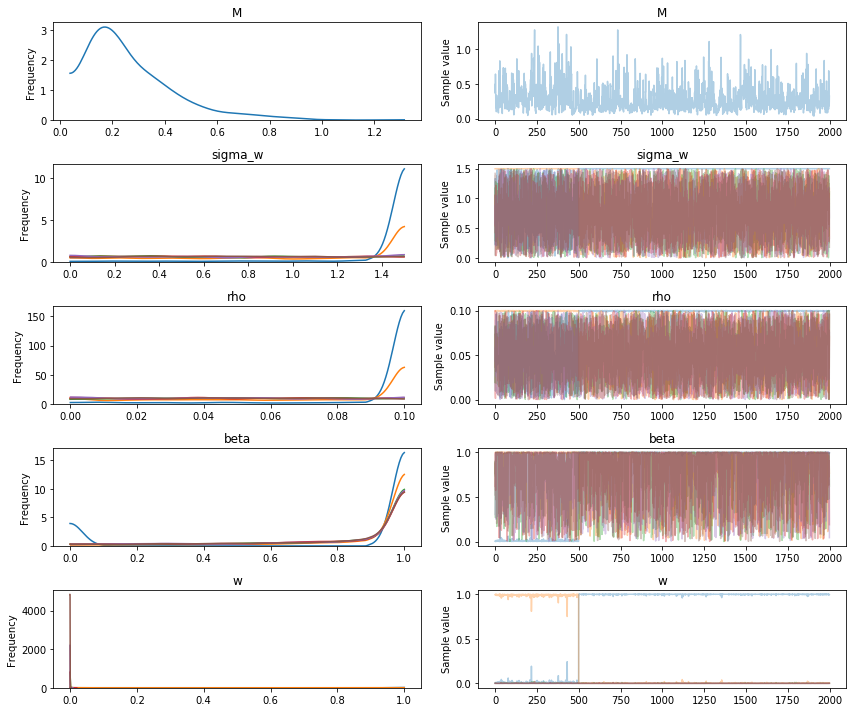

In [25]:
pm.traceplot(trace, combined=True);

In [6]:
K = 6  # the number of mixed components
N = 200  # the number of observed individuals
n = 5  # each individual was observed 5 times

e = np.ones(n)
I = np.eye(n)
mu0 = np.linspace(0.0, 0.0, num=n)

# simulate observation data
C1 = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        if i == j:
            C1[i, j] = 10.0
        else:
            C1[i, j] = 7.0

dataSet1 = np.random.multivariate_normal(mu0, C1, size=N)

# observation time(all individuals are observed at the same times)
time_obseved = [-4.0, -1.0, 0.0, 1.5, 2.0]
time = np.array(time_obseved)

H0 = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        H0[i, j] = np.abs(time[j] - time[i])

In [9]:
with pm.Model() as model:
    M = pm.Gamma('M', 1., 1.)

    sigma_w = pm.Uniform('sigma_w', 0.0, 1.5, shape=K)
    rho = pm.Uniform('rho', 0.0, 0.1, shape=K)

    beta = pm.Beta('beta', 1., M, shape=K)
    w0 = stick_breaking(beta)
    w = pm.Deterministic('w', w0 / w0.sum())

    compdist = []
    for i in range(K):
        compdist.append(
            pm.MvNormal.dist(
                mu=mu0, cov=sigma_w[i]**2 * tt.pow(rho[i], H0)))

    # n dimensional random variable omega obeys a multicomponent mixture distribution
    # omega = pm.Mixture('omega', w, compdist, shape=dataSet1.shape)
    omega = pm.Mixture('omega', w, compdist, shape=(1, n))
    
    mu = pm.Normal('mu', mu=0.0, sd=1.0)
    sigma = pm.Uniform('sigma', 0.0, 1.0)
    xi = pm.InverseGamma('xi', 1.0, 1.0)
    b = pm.Normal('b', mu=0.0, sd=tt.sqrt(xi), shape=(N, 1))

    mu2 = (mu + b) * e + omega

    y = pm.Normal(
        'y', mu=mu2, sd=sigma**2,
        observed=dataSet1)  #y_i~N(mu=(mu+b_i)*e+omega_i,cov=sigma**2*I)

In [12]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, xi_log__, sigma_interval__, mu, omega, beta_logodds__, rho_interval__, sigma_w_interval__, M_log__]
100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


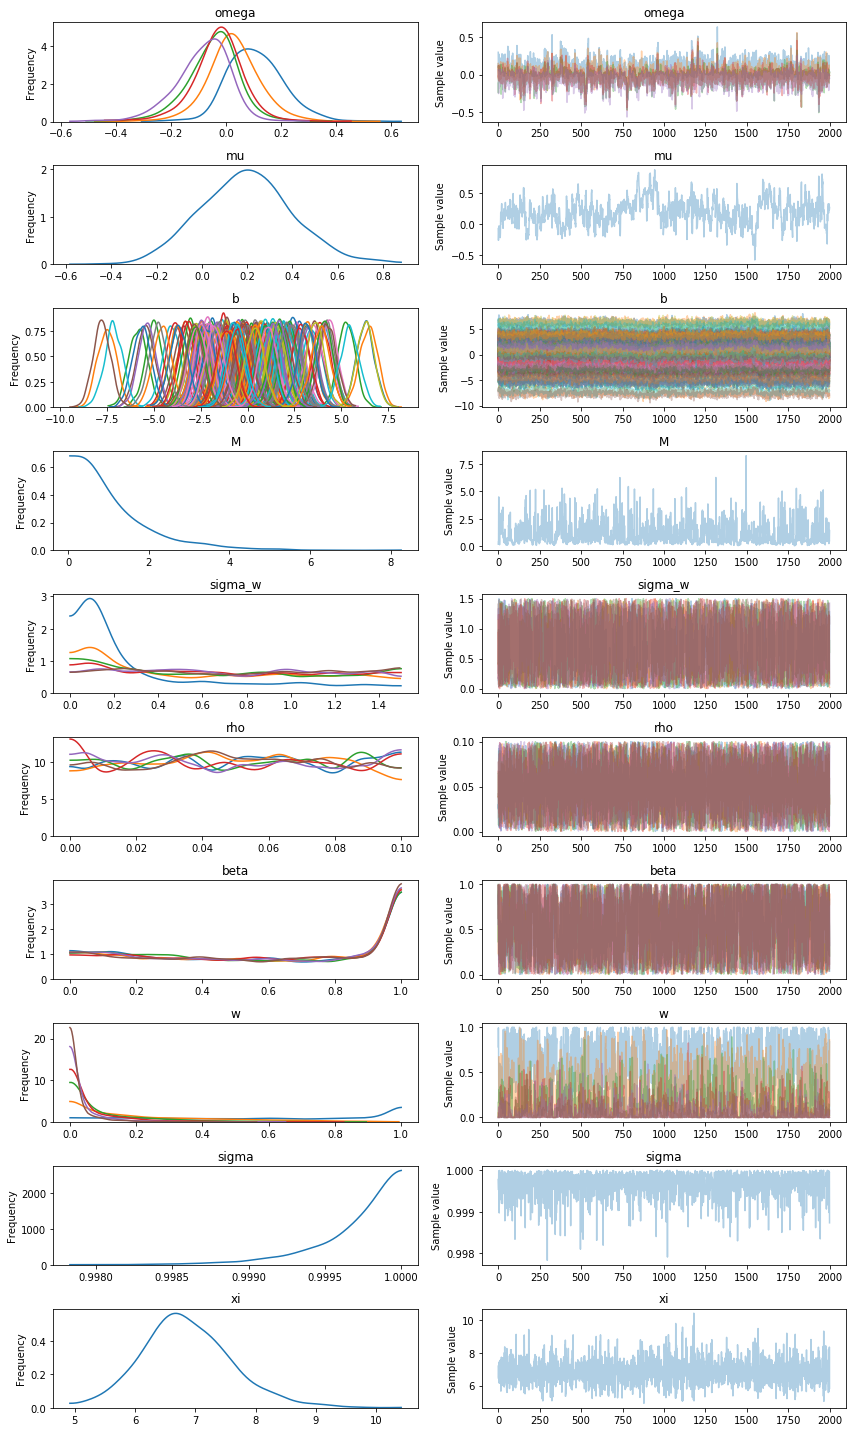

In [14]:
pm.traceplot(trace, combined=True);

In [71]:
sigma_rho = np.asarray([0.99017059, -1.])
cov = (np.identity(n)*sigma_rho[0]**2) * np.power(sigma_rho[1], H0)
np.linalg.cholesky(cov), np.power(sigma_rho[1], H0)

(array([[ 0.99017059,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.        ,  0.99017059,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.        ,  0.99017059,  0.        ,  0.        ],
        [        nan,         nan,         nan,         nan,  0.        ],
        [ 0.        , -0.        ,  0.        ,         nan,         nan]]),
 array([[ 1., -1.,  1., nan,  1.],
        [-1.,  1., -1., nan, -1.],
        [ 1., -1.,  1., nan,  1.],
        [nan, nan, nan,  1., nan],
        [ 1., -1.,  1., nan,  1.]]))

In [70]:
for i in range(100):
    sigma_rho = np.random.randn(2)*[2.0, 0.5]
    cov = (np.identity(n)*sigma_rho[0]**2) * np.power(sigma_rho[1], H0)
    chol = np.linalg.cholesky(cov)
    if ~np.isfinite(chol).all():
        print('bad sigma', sigma_rho)

In [59]:
np.isfinite(chol)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [False, False, False, False,  True],
       [ True,  True,  True, False, False]])

In [ ]:
with pm.Model() as model:

    M = pm.Gamma('M', 1., 1.)

    sigma_rho = pm.Normal('sigma_w', mu=np.array(
        [2.0, 0.5]), sd=0.5, shape=(K, 2))
    #rho =pm.Uniform('rho',0.0,1.0,shape=K)

    w = pm.Dirichlet('w', np.ones(K))

    compdist = []
    for i in range(K):
        compdist.append(pm.MvNormal.dist(
            mu=mu0, cov=sigma_rho[i, 0]**2 * tt.pow(sigma_rho[i, 1], H0)))

    omega = pm.Mixture('omega', w, compdist, shape=(1, n))

    mu = pm.Normal('mu', mu=0.0, sd=1.0)
    xi = pm.InverseGamma('xi', 1.0, 1.0)
    b = pm.Normal('b', mu=0.0, sd=tt.sqrt(xi), shape=(N, 1))

    mu2 = (mu + b) * e + omega

    y = pm.Normal('y', mu=mu2, sd=2.0, observed=dataSet1)